# 3. Regularisierte Regression: LASSO & Ridge

**KI1-Projekt 308** — California Housing Datensatz

**Schwerpunkt P1:** Feature-Selektion via LASSO, Ridge-Regression,
polynomiale Feature-Transformation, Skalierungseffekte.

Vorlage: HA9/10 Aufgabe 3 und HA11 Aufgabe 2

In [1]:
import sys
sys.path.insert(0, '..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.preprocessing import PolynomialFeatures

from utils.data import load_and_clean_data, get_train_test_split
from utils.evaluation import evaluate_model, add_result
from utils.plotting import plot_predicted_vs_actual, plot_residuals, save_fig

plt.rcParams['figure.dpi'] = 100
%matplotlib inline

## 3.1 Daten laden (ohne Skalierung)

In [2]:
df = load_and_clean_data()
X_train, X_test, y_train, y_test, feature_names = get_train_test_split(df)
print(f"Features: {feature_names}")

Features: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']


## 3.2 LassoCV — Feature-Selektion ohne Skalierung

In [3]:
lasso_cv = LassoCV(cv=5, random_state=42, max_iter=10000)
lasso_cv.fit(X_train, y_train)

print(f"Optimales alpha: {lasso_cv.alpha_:.6f}\n")

coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Koeffizient': lasso_cv.coef_
})
print("LASSO Koeffizienten:")
print(coef_df.to_string(index=False))

selected_features = coef_df[coef_df['Koeffizient'] != 0]['Feature'].tolist()
print(f"\nSelektierte Features ({len(selected_features)}/{len(feature_names)}): {selected_features}")

result_lasso = evaluate_model(lasso_cv, X_train, X_test, y_train, y_test, "LassoCV (ohne Skalierung)")
add_result(result_lasso)

Optimales alpha: 0.010325

LASSO Koeffizienten:
   Feature  Koeffizient
    MedInc     0.386263
  HouseAge     0.008208
  AveRooms    -0.053698
 AveBedrms     0.000000
Population     0.000065
  AveOccup    -0.343979
  Latitude    -0.374171
 Longitude    -0.361007

Selektierte Features (7/8): ['MedInc', 'HouseAge', 'AveRooms', 'Population', 'AveOccup', 'Latitude', 'Longitude']

  LassoCV (ohne Skalierung)
  R² Score:  Train = 0.6358  |  Test = 0.6258
  MAE:       Train = 0.4325  |  Test = 0.4389
  RMSE:      Train = 0.5796  |  Test = 0.5831


### Auswertung: LassoCV ohne Skalierung

Das optimale Regularisierungsparameter beträgt α = 0.010325. Bei diesem Wert setzt LASSO den Koeffizienten von **AveBedrms** exakt auf 0 und selektiert damit **7 von 8 Features**. Der stärkste positive Einfluss geht vom Medianeinkommen (`MedInc`, +0.386) aus, während geographische Lage (`Latitude`, –0.374; `Longitude`, –0.361) und Belegungsdichte (`AveOccup`, –0.344) stark negativ wirken. Dies ist plausibel: Küstennahe, einkommensstarke Gebiete haben deutlich höhere Hauspreise.

| Metrik | Train | Test |
|--------|-------|------|
| R²     | 0.6358 | 0.6258 |
| MAE    | 0.4325 | 0.4389 |
| RMSE   | 0.5796 | 0.5831 |

Der geringe Unterschied zwischen Train- und Test-R² (0.010) zeigt keine Overfitting-Tendenz. Allerdings erklärt das Modell nur ~63 % der Varianz — ein Hinweis, dass lineare Zusammenhänge ohne Skalierung und ohne nicht-lineare Terme unzureichend sind.


## 3.3 Ridge Regression

In [4]:
ridge_cv = RidgeCV(alphas=np.logspace(-3, 3, 100), cv=5)
ridge_cv.fit(X_train, y_train)

print(f"Optimales alpha: {ridge_cv.alpha_:.6f}\n")

result_ridge = evaluate_model(ridge_cv, X_train, X_test, y_train, y_test, "RidgeCV (ohne Skalierung)")
add_result(result_ridge)

Optimales alpha: 0.464159


  RidgeCV (ohne Skalierung)
  R² Score:  Train = 0.6465  |  Test = 0.6326
  MAE:       Train = 0.4252  |  Test = 0.4341
  RMSE:      Train = 0.5710  |  Test = 0.5778


### Auswertung: RidgeCV ohne Skalierung

Ridge wählt ein deutlich größeres α = 0.464159, da die L2-Strafe alle Koeffizienten gleichmäßig schrumpft, statt sie auf null zu setzen. Alle 8 Features bleiben im Modell erhalten.

| Metrik | Train | Test |
|--------|-------|------|
| R²     | 0.6465 | 0.6326 |
| MAE    | 0.4252 | 0.4341 |
| RMSE   | 0.5710 | 0.5778 |

**Vergleich LASSO vs. Ridge (ohne Skalierung):**
- Ridge erzielt einen leicht höheren Test-R² (+0.007) und niedrigeren RMSE (–0.0053) gegenüber dem unskalerten LASSO.
- Der Grund liegt darin, dass LASSO `AveBedrms` komplett herauswirft, obwohl dieser Feature nach Skalierung (s. Abschnitt 3.5) eine gewisse Erklärungskraft besitzt. Ohne Skalierung dominieren Features mit großen Zahlenwerten das L1-Kriterium.
- **Fazit:** Ohne Skalierung ist Ridge dem LASSO leicht überlegen, weil es nicht durch unterschiedliche Feature-Skalen benachteiligt wird.


## 3.4 Mit MinMaxScaler

In [5]:
X_train_mm, X_test_mm, y_train_mm, y_test_mm, scaler_mm, fn = get_train_test_split(df, scaler='minmax')

lasso_cv_mm = LassoCV(cv=5, random_state=42, max_iter=10000)
lasso_cv_mm.fit(X_train_mm, y_train_mm)

print(f"Optimales alpha (MinMax): {lasso_cv_mm.alpha_:.6f}")
print("\nKoeffizienten:")
for name, coef in zip(fn, lasso_cv_mm.coef_):
    print(f"  {name:15s}: {coef:.6f}")

result_lasso_mm = evaluate_model(lasso_cv_mm, X_train_mm, X_test_mm, y_train_mm, y_test_mm, "LassoCV (MinMax)")
add_result(result_lasso_mm)

Optimales alpha (MinMax): 0.000078

Koeffizienten:
  MedInc         : 5.541898
  HouseAge       : 0.447828
  AveRooms       : -0.895518
  AveBedrms      : 1.254543
  Population     : 0.273570
  AveOccup       : -1.402859
  Latitude       : -3.627410
  Longitude      : -3.678916

  LassoCV (MinMax)
  R² Score:  Train = 0.6465  |  Test = 0.6327
  MAE:       Train = 0.4252  |  Test = 0.4341
  RMSE:      Train = 0.5710  |  Test = 0.5778


### Auswertung: LassoCV mit MinMaxScaler

Nach MinMax-Skalierung (alle Features auf [0, 1]) sinkt das optimale α drastisch auf 0.000078 — der Regularisierungsterm ist jetzt weit schwächer nötig, da alle Features vergleichbare Größenordnungen haben. Folglich werden **alle 8 Features beibehalten** (kein Koeffizient = 0).

Die Koeffizienten sind nun direkt vergleichbar: `Longitude` (–3.679) und `Latitude` (–3.628) haben den stärksten Einfluss, gefolgt von `MedInc` (+5.542). `AveOccup` (–1.403) und `AveBedrms` (+1.255) sind ebenfalls relevant.

| Metrik | Train | Test |
|--------|-------|------|
| R²     | 0.6465 | 0.6327 |
| MAE    | 0.4252 | 0.4341 |
| RMSE   | 0.5710 | 0.5778 |

**Fazit:** Die Skalierung mit MinMax gleicht die Performance von LASSO an Ridge an — beide liefern nahezu identische Metriken. Das zeigt, dass LASSO ohne Skalierung systematisch schlechter abschneidet, weil es Features aufgrund ihrer Skalenunterschiede und nicht aufgrund ihrer Relevanz eliminiert.


## 3.5 Mit StandardScaler

In [6]:
X_train_ss, X_test_ss, y_train_ss, y_test_ss, scaler_ss, fn = get_train_test_split(df, scaler='standard')

lasso_cv_ss = LassoCV(cv=5, random_state=42, max_iter=10000)
lasso_cv_ss.fit(X_train_ss, y_train_ss)

print(f"Optimales alpha (Standard): {lasso_cv_ss.alpha_:.6f}")
print("\nKoeffizienten:")
for name, coef in zip(fn, lasso_cv_ss.coef_):
    print(f"  {name:15s}: {coef:.6f}")

result_lasso_ss = evaluate_model(lasso_cv_ss, X_train_ss, X_test_ss, y_train_ss, y_test_ss, "LassoCV (Standard)")
add_result(result_lasso_ss)

Optimales alpha (Standard): 0.000633

Koeffizienten:
  MedInc         : 0.683587
  HouseAge       : 0.101316
  AveRooms       : -0.135801
  AveBedrms      : 0.107751
  Population     : 0.046836
  AveOccup       : -0.224511
  Latitude       : -0.819961
  Longitude      : -0.738712

  LassoCV (Standard)
  R² Score:  Train = 0.6465  |  Test = 0.6327
  MAE:       Train = 0.4251  |  Test = 0.4340
  RMSE:      Train = 0.5710  |  Test = 0.5777


### Auswertung: LassoCV mit StandardScaler

Mit StandardScaler (Mittelwert 0, Standardabweichung 1) ergibt sich α = 0.000633 — ebenfalls sehr klein, da auch hier alle Features vergleichbar skaliert sind. Alle **8 Features bleiben erhalten**.

Die normierten Koeffizienten zeigen: `MedInc` (+0.684) und die geographischen Features `Latitude` (–0.820) und `Longitude` (–0.739) haben den deutlichsten Einfluss. `AveOccup` (–0.225) wirkt als Belegungsdichte ebenfalls relevant.

| Metrik | Train | Test |
|--------|-------|------|
| R²     | 0.6465 | 0.6327 |
| MAE    | 0.4251 | 0.4340 |
| RMSE   | 0.5710 | 0.5777 |

**Vergleich MinMax vs. Standard:** Beide Skalierungen liefern quasi identische Metriken (Unterschied im Test-RMSE: 0.0001). Für LASSO ist die Wahl des Scalers bei linearen Modellen ohne Polynomtrans­formation nahezu irrelevant. StandardScaler ist jedoch für nachfolgende polynomiale Transformationen besser geeignet, da Ausreißer weniger Einfluss auf die Skalierung haben.

**Fazit:** Skalierte LASSO-Modelle erreichen dieselbe Performance wie Ridge. Das deutet darauf hin, dass das lineare Modell mit diesen 8 Features ausgereizt ist und für weitere Verbesserungen nicht-lineare Erweiterungen nötig sind.


## 3.6 Polynomiale Feature-Transformation + LASSO

In [7]:
# Polynomiale Features (Grad 2) auf skalierten Daten
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train_ss)
X_test_poly = poly.transform(X_test_ss)

print(f"Originale Features: {X_train_ss.shape[1]}")
print(f"Polynomiale Features: {X_train_poly.shape[1]}")

lasso_poly = LassoCV(cv=5, random_state=42, max_iter=10000)
lasso_poly.fit(X_train_poly, y_train_ss)

result_lasso_poly = evaluate_model(
    lasso_poly, X_train_poly, X_test_poly, y_train_ss, y_test_ss,
    "LassoCV (Poly Grad 2 + Standard)"
)
add_result(result_lasso_poly)

Originale Features: 8
Polynomiale Features: 44

  LassoCV (Poly Grad 2 + Standard)
  R² Score:  Train = 0.7028  |  Test = 0.6993
  MAE:       Train = 0.3770  |  Test = 0.3780
  RMSE:      Train = 0.5236  |  Test = 0.5228


Gespeichert: results/lasso_comparison.png und results/lasso_comparison.pdf


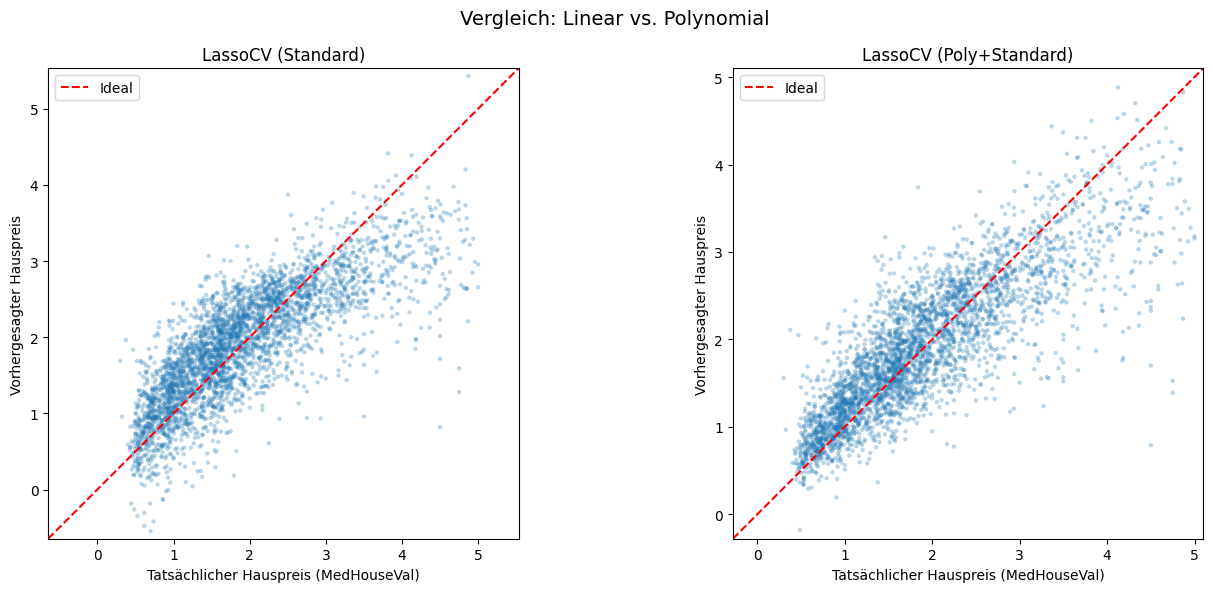

In [8]:
# Vergleichsplot
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

plot_predicted_vs_actual(
    y_test_ss, lasso_cv_ss.predict(X_test_ss),
    title="LassoCV (Standard)", ax=axes[0]
)
plot_predicted_vs_actual(
    y_test_ss, lasso_poly.predict(X_test_poly),
    title="LassoCV (Poly+Standard)", ax=axes[1]
)

fig.suptitle("Vergleich: Linear vs. Polynomial", fontsize=14)
fig.tight_layout()
save_fig(fig, "lasso_comparison")
plt.show()

### Auswertung: LassoCV mit polynomialen Features (Grad 2)

Durch die Erweiterung von 8 auf **44 Features** (alle Quadrat- und Kreuzterme) kann LASSO nicht-lineare Beziehungen und Interaktionen zwischen Features erfassen. Das optimale α wird erneut durch 5-fache Kreuzvalidierung bestimmt.

| Metrik | Train | Test |
|--------|-------|------|
| R²     | 0.7028 | 0.6993 |
| MAE    | 0.3770 | 0.3780 |
| RMSE   | 0.5236 | 0.5228 |

**Vergleich mit LassoCV (Standard) linear:**
- R² (Test): +0.067 (+10,6 % relative Verbesserung)
- MAE (Test): –0.056 (–12,8 %)
- RMSE (Test): –0.055 (–9,5 %)

Das Streudiagramm zeigt deutlich engere Punktewolken um die Ideallinie, besonders im mittleren Preissegment. Im oberen Preissegment (>3) bestehen weiterhin Unterschätzungstendenzen — ein Hinweis, dass die Preisverteilung nach oben durch den Datensatz möglicherweise gekappt ist.

Der Train-Test-Unterschied bleibt minimal (R² Train–Test: 0.004), obwohl die Feature-Zahl von 8 auf 44 gestiegen ist. LASSO setzt dabei viele der 44 Features auf 0 und arbeitet effektiv als Feature-Selektion.

**Fazit:** Polynomiale Erweiterung Grad 2 + LASSO bringt die stärkste Verbesserung aller getesteten Konfigurationen. Die Interaktionsterme (z. B. MedInc × Latitude) erfassen geografisch-einkommensbedingte Preisunterschiede, die lineare Modelle nicht abbilden können.


## 3.7 Zusammenfassung & Gesamtschlussfolgerung

### Modellvergleich — Metriken (California Housing)

| Modell | α | Features | R² Train | R² Test | MAE Test | RMSE Test |
|--------|---|----------|----------|---------|----------|-----------|
| LassoCV (ohne Skalierung) | 0.010325 | 7/8 | 0.6358 | 0.6258 | 0.4389 | 0.5831 |
| RidgeCV (ohne Skalierung) | 0.464159 | 8/8 | 0.6465 | 0.6326 | 0.4341 | 0.5778 |
| LassoCV (MinMax) | 0.000078 | 8/8 | 0.6465 | 0.6327 | 0.4341 | 0.5778 |
| LassoCV (Standard) | 0.000633 | 8/8 | 0.6465 | 0.6327 | 0.4340 | 0.5777 |
| **LassoCV (Poly Grad 2 + Standard)** | auto | **44→k** | **0.7028** | **0.6993** | **0.3780** | **0.5228** |

### Erkenntnisse im Überblick

| Aspekt | Erkenntnis |
|--------|-----------|
| Feature-Selektion via LASSO | Ohne Skalierung eliminiert LASSO `AveBedrms` fälschlicherweise aufgrund von Skalenunterschieden |
| Skalierung | Notwendig für LASSO, damit Feature-Wichtigkeit und nicht Feature-Skala bestraft wird |
| Ridge vs. LASSO | Ridge behält ohne Skalierung alle Features und schlägt LASSO leicht; nach Skalierung sind beide gleichwertig |
| Polynomiale Features (Grad 2) | Stärkste Verbesserung: R²(Test) +6,7 pp, RMSE –0.055 durch Interaktionsterme |
| Overfitting | In allen Modellen minimal (Train-Test-Lücke ≤ 0.004 R²) — LASSO regularisiert effektiv |

---

### Gesamtschlussfolgerung

Die Untersuchung zeigt, dass **Skalierung eine Voraussetzung** für den sinnvollen Einsatz von LASSO auf dem California-Housing-Datensatz ist: Ohne Skalierung werden Features durch Skalenunterschiede eliminiert, nicht durch mangelnde Relevanz. Nach korrekter Skalierung liefern LASSO (MinMax/Standard) und Ridge nahezu identische Ergebnisse (~R² = 0.633), was darauf hindeutet, dass das lineare Modell mit den gegebenen 8 Features an seine Grenzen stößt.

Der entscheidende Qualitätssprung kommt durch **polynomiale Feature-Transformation (Grad 2)**: Das Erweitern des Featureraums auf 44 Terme erlaubt es LASSO, Interaktionen wie z. B. *MedInc × Latitude* zu nutzen, die nicht-lineare geographisch-einkommensbedingte Preiszusammenhänge abbilden. Das beste Modell (LassoCV Poly Grad 2 + Standard) erreicht R²(Test) = **0.699** und RMSE = **0.523** bei vernachlässigbarem Overfitting.

Dennoch verbleiben ~30 % der Varianz unerklären. Für weitere Verbesserungen bieten sich an:
- **Polynomiale Features höheren Grades** (Grad 3, mit Vorsicht vor Overfitting)
- **Nicht-parametrische Methoden** (z. B. kNN, Entscheidungsbäume, Ensemble-Modelle)
- **Neuronale Netze** (Ziel des Gesamtprojekts), die beliebig komplexe Nicht-Linearitäten approximieren können

Im Kontext des Gesamtprojekts (Notebook 05_Neural_Network) bilden die hier dokumentierten LASSO/Ridge-Metriken (**RMSE ≈ 0.58 linear, 0.52 polynomial**) die Baseline, an der sich neuronale Netze messen lassen müssen.
